In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [59]:
df = pd.read_excel("Indicadores.xlsx")

In [60]:
# Dividirlo por periodo
df['Periodo'] = pd.to_datetime(df['Periodo'])

In [61]:
df = df.sort_values(by="Periodo")

In [62]:
df = df.set_index("Periodo")

In [63]:
df

,Valor
Periodo,
1993-01-01,60.407691
1993-02-01,61.022521
1993-03-01,63.943249
1993-04-01,61.865984
1993-05-01,63.612900
...,...
2022-03-01,111.940152
2022-04-01,109.529866
2022-05-01,114.442424


<AxesSubplot:xlabel='Periodo'>

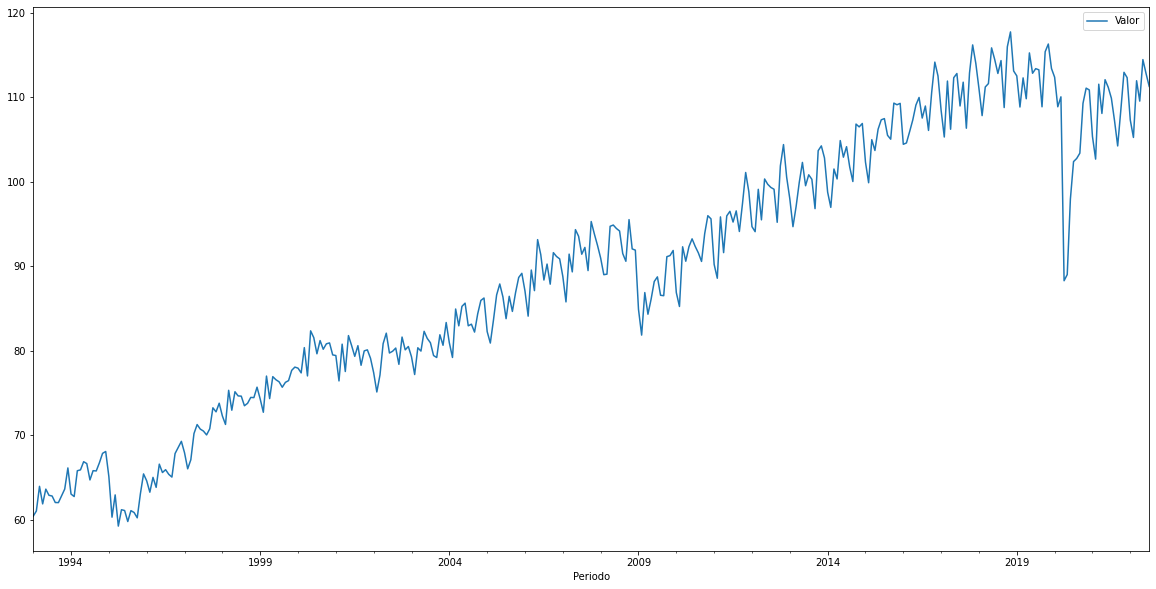

In [64]:
df.plot(figsize=(20,10))

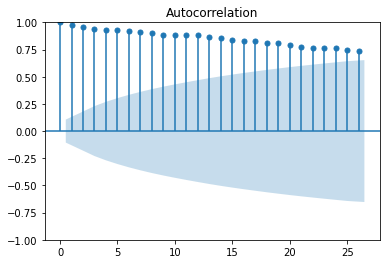

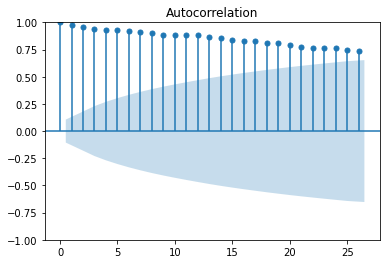

In [85]:
plot_acf(df["Valor"])

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


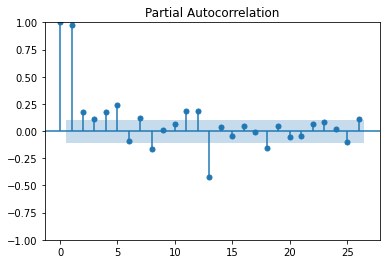

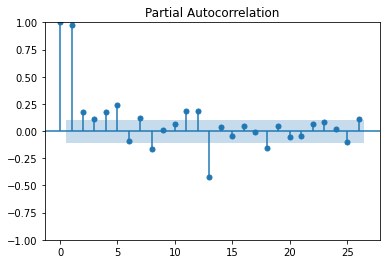

In [86]:
plot_pacf(df["Valor"])

In [66]:
#p-value
adfuller(df)[1]

0.7848372900898413

Al graficar los datos y ejecutar la función para obtener p-value, damos cuenta que no es estacionaria y aún no es adecuado aplicar los modelos de ARIMA-SARIMA; por lo tanto, debemos aplicar el logaritmo y usar la función de shift para convertirlo a estacionaria.


In [67]:
df['Valor_log'] = np.log(df['Valor'])

In [68]:
df['Aux'] = df["Valor_log"] - df["Valor_log"].shift(12)

In [69]:
df

,Valor,Valor_log,Aux
Periodo,,,
1993-01-01,60.407691,4.101116,NaN
1993-02-01,61.022521,4.111243,NaN
1993-03-01,63.943249,4.157996,NaN
1993-04-01,61.865984,4.124970,NaN
1993-05-01,63.612900,4.152816,NaN
...,...,...,...
2022-03-01,111.940152,4.717964,0.003661
2022-04-01,109.529866,4.696197,0.013414
2022-05-01,114.442424,4.740072,0.021001


Eliminamos las filas que contiene Nans

In [70]:
df.dropna(inplace=True)

In [71]:
df.reset_index()

,Periodo,Valor,Valor_log,Aux
0,1994-01-01,63.029268,4.143599,0.042483
1,1994-02-01,62.733156,4.138890,0.027647
2,1994-03-01,65.790275,4.186472,0.028476
3,1994-04-01,65.891716,4.188013,0.063042
4,1994-05-01,66.858802,4.202583,0.049767
...,...,...,...,...
338,2022-03-01,111.940152,4.717964,0.003661
339,2022-04-01,109.529866,4.696197,0.013414
340,2022-05-01,114.442424,4.740072,0.021001
341,2022-06-01,112.797501,4.725594,0.014522


In [72]:
df_aux = df.copy()

In [73]:
df_aux.drop(["Valor", "Valor_log"], axis=1 , inplace=True)

In [74]:
df_aux

,Aux
Periodo,
1994-01-01,0.042483
1994-02-01,0.027647
1994-03-01,0.028476
1994-04-01,0.063042
1994-05-01,0.049767
...,...
2022-03-01,0.003661
2022-04-01,0.013414
2022-05-01,0.021001


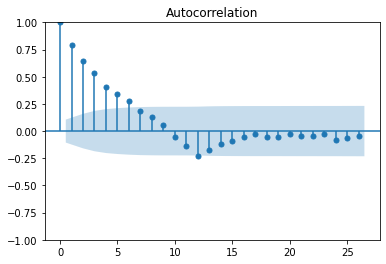

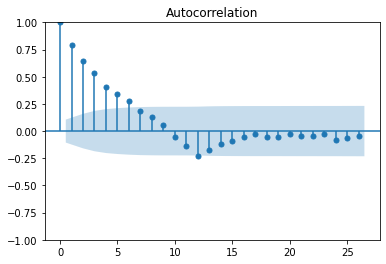

In [84]:
plot_acf(df_aux)

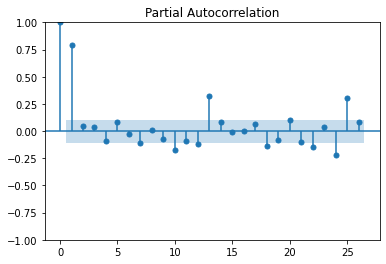

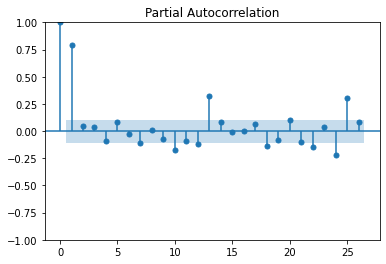

In [87]:
plot_pacf(df_aux)

In [75]:
#p-value
adfuller(df_aux)[1]

0.003260263568859351

En la primera gráfica de autocorrelación podemos notar que los datos ya son estacionarios y listo para aplicar el modelo de ARIMA-SARIMA. Al contrario en la segunda gráfica de autocorrelación parcial no presenta ningún estacionariedad.

Analizando que al convertir los datos a estacionario, observamos que el p-value ya redujo hasta menos de 0.05, lo cual podemos usar el parámetro D = 1, p = 1, q = 0.

### Modelo 1

In [101]:
# Parametros order (P, d, q), seasonal_order(P, D, Q, period)
sarima_model = sm.tsa.statespace.SARIMAX(df_aux['Aux'], order=(0, 0, 1), seasonal_order = (0, 1, 0, 12),  simple_differencing=True)
model = sarima_model.fit()

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [102]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            DS12.Aux   No. Observations:                  331
Model:             SARIMAX(0, 0, 1)x(0, 0, [], 12)   Log Likelihood                 495.201
Date:                             Fri, 21 Oct 2022   AIC                           -986.402
Time:                                     21:43:06   BIC                           -978.798
Sample:                                 01-01-1995   HQIC                          -983.369
                                      - 07-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6509      0.029     22.576      0.000       0.594       0.707
sigma2         0.0029      

Al entranar nuestro primer modelo, podemos ver que el error estándar son cifras menores y nuestro p-value es menos de 0.05 lo cual es favorable para visualizar que el modelo es útil. Para visualizar mejor, utilizamos la misma función de autocorrelaciones para visualizar sus valores.

In [111]:
model.resid

Periodo
1995-01-01   -0.010122
1995-02-01   -0.062674
1995-03-01   -0.036701
1995-04-01   -0.146667
1995-05-01   -0.044915
                ...   
2022-03-01   -0.032341
2022-04-01   -0.167875
2022-05-01   -0.100107
2022-06-01   -0.047156
2022-07-01   -0.027441
Length: 331, dtype: float64

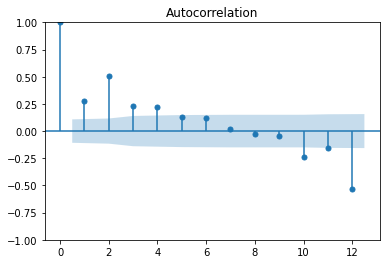

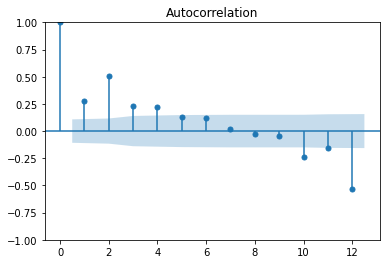

In [104]:
plot_acf(model.resid, lags=12) # lags 12 meses = 1 año

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


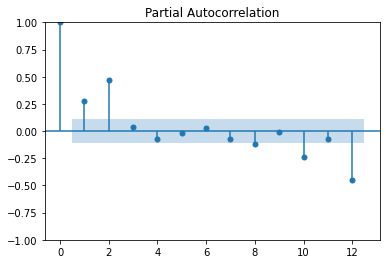

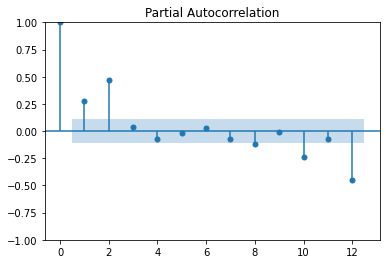

In [105]:
plot_pacf(model.resid, lags=12) # lags 12 meses = 1 año

A la simple vista ambas gráficas de autocorrelación se ven iguales, notamos que pierde un poco la estacionariedad en la primera gráfica con el segundo y la penúltima lags. 

### Modelo 2 (P=1)

In [139]:
# Parametros order (P, d, q), seasonal_order(P, D, Q, period)
sarima_model2 = sm.tsa.statespace.SARIMAX(df_aux['Aux'], order=(1, 0, 1), seasonal_order = (1, 1, 1, 12),  simple_differencing=True)
model2 = sarima_model2.fit()

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [140]:
print(model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           DS12.Aux   No. Observations:                  331
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 708.556
Date:                            Fri, 21 Oct 2022   AIC                          -1407.112
Time:                                    22:34:55   BIC                          -1388.101
Sample:                                01-01-1995   HQIC                         -1399.530
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8554      0.035     24.702      0.000       0.788       0.923
ma.L1         -0.1363      0.050   

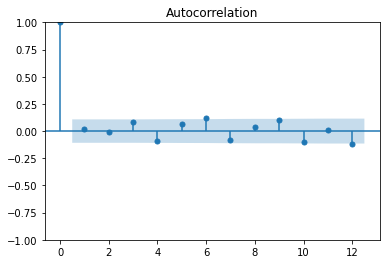

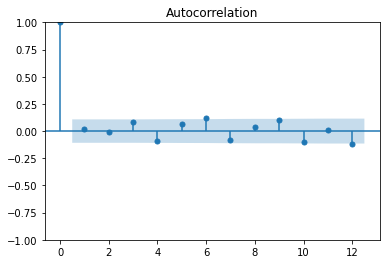

In [141]:
plot_acf(model2.resid, lags=12) # lags 12 meses = 1 año

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


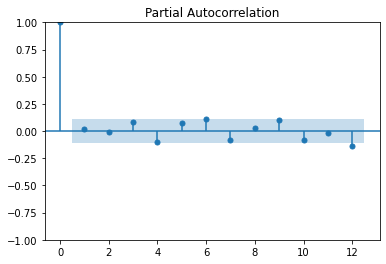

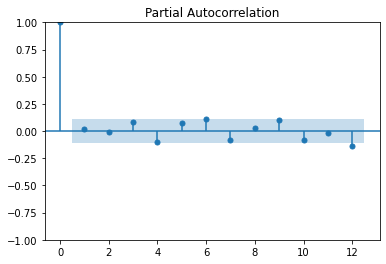

In [142]:
plot_pacf(model2.resid, lags=12) # lags 12 meses = 1 año

Vemos al aplicar P=1, observamos que sólo el primer lags tiene el valor muy significativo y otros lags mantienen en su promedio.